# Actividad 4: Clasificación y evaluación de un modelo



*   Dilan González Castañeda A00831905

La primera columna de la base de datos ("Class") es la variable que se quiere predecir. El valor "p"  representa hongos venenosos (poisonous), el valor "e" representa hongos no venenosos (edible).

**Instrucciones:**

*  Puedes elegir cualquier tipo de clasificador. Dado que todas las variables son de tipo categórico, recuerda que deberás hacer uso de "dummy variables" para poder usar el algoritmo de clasificación.
* El clasificador que selecciones debe de realizar 5 calibraciones y justificar cual es el que da el mejor resultado.
Debes evaluar el modelo de clasificación utilizando:
* Calcula la matriz de confusión de tu modelo
* Calcula la sensibilidad y la especificidad de tu modelo
* Genera la curva ROC y calcula la AUC para tu modelo
* Realiza un tipo de validación cruzada y comenta los resultados obtenidos del análisis completo
* Concluye sobre los mejores y peores resultados.



## Importing Required Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

## Loading data

In [17]:
data = pd.read_csv("https://raw.githubusercontent.com/Fat1304/Dataset-del-reto/main/mushrooms.csv")

In [18]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Selección de tipo de clasificador

In [19]:
def info_df(df):
    """
    This function returns a dataframe with the following information for each column:
    - Column name
    - Data type
    - Number of unique values
    - Number of NaN values
    - Number of non-NaN values
    """

    print(f'The dataframe has {df.shape[1]} columns and {df.shape[0]} rows')
    print(f'dtype: object({df.select_dtypes(include="object").shape[1]}), int64({df.select_dtypes(include="int64").shape[1]}), float64({df.select_dtypes(include="float64").shape[1]})')

    temp_df = pd.DataFrame(columns=['Column', 'dtype', 'Unique Values', 'nan', 'size'])
    
    for column in df.columns:
        unique_values = [df[column].unique()]  # Ensure unique values are in a list
        temp_df = pd.concat([temp_df, pd.DataFrame({'Column': [column], 'dtype': [df[column].dtype], 'Unique Values': unique_values})], ignore_index=True)
        temp_df.loc[temp_df['Column'] == column, 'nan'] = df[column].isnull().sum()
        temp_df.loc[temp_df['Column'] == column, 'size'] = df[column].count()
    
    return temp_df

info_df(data)

The dataframe has 23 columns and 8124 rows
dtype: object(23), int64(0), float64(0)


,Column,dtype,Unique Values,nan,size
0,class,object,"[p, e]",0,8124
1,cap-shape,object,"[x, b, s, f, k, c]",0,8124
2,cap-surface,object,"[s, y, f, g]",0,8124
3,cap-color,object,"[n, y, w, g, e, p, b, u, c, r]",0,8124
4,bruises,object,"[t, f]",0,8124
5,odor,object,"[p, a, l, n, f, c, y, s, m]",0,8124
6,gill-attachment,object,"[f, a]",0,8124
7,gill-spacing,object,"[c, w]",0,8124
8,gill-size,object,"[n, b]",0,8124
9,gill-color,object,"[k, n, g, p, w, h, u, e, b, r, y, o]",0,8124


In [20]:
# Create a deep copy of the dataset
data_encoded = data.copy(deep=True)
pd.set_option('future.no_silent_downcasting', True)

# Drop the column with 1 unique value
data_encoded = data_encoded.drop('veil-type', axis=1)

# Label encoding for specific columns
data_encoded['class'] = data_encoded['class'].replace({'e': 0, 'p': 1}).astype(int)  # 0: edible, 1: poisonous
data_encoded['ring-number'] = data_encoded['ring-number'].replace({'n': 0, 'o': 1, 't': 2}).astype(int)  # 0: none, 1: one, 2: two

# Define columns to one-hot encode
cols = [col for col in data.columns if col not in ['class', 'veil-type', 'ring-number']]
encoders = {}

for col in cols:
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids dummy variable trap

    # Apply one-hot encoding to the current column
    one_hot_encoded = encoder.fit_transform(data_encoded[[col]])

    # Create a DataFrame with the one-hot encoded columns
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([col]), index=data_encoded.index)

    # Concatenate the one-hot encoded columns with the original data
    data_encoded = pd.concat([data_encoded, one_hot_df], axis=1)

    # Drop the original categorical column
    data_encoded = data_encoded.drop(col, axis=1)

    # Save the encoder for later use if needed
    encoders[col] = encoder

In [21]:
data_encoded.head()

,class,ring-number,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
info_df(data_encoded)

The dataframe has 95 columns and 8124 rows
dtype: object(0), int64(0), float64(93)


,Column,dtype,Unique Values,nan,size
0,class,int32,"[1, 0]",0,8124
1,ring-number,int32,"[1, 2, 0]",0,8124
2,cap-shape_c,float64,"[0.0, 1.0]",0,8124
3,cap-shape_f,float64,"[0.0, 1.0]",0,8124
4,cap-shape_k,float64,"[0.0, 1.0]",0,8124
...,...,...,...,...,...
90,habitat_l,float64,"[0.0, 1.0]",0,8124
91,habitat_m,float64,"[0.0, 1.0]",0,8124
92,habitat_p,float64,"[0.0, 1.0]",0,8124
93,habitat_u,float64,"[1.0, 0.0]",0,8124


##Calibraciones

In [23]:
# DataFrame for chart
D = []
T = []
H = []

# Split dataset into features and target variable
X = data_encoded.drop('class', axis=1)
y = data_encoded['class']

# Define the number of folds for K-Fold cross-validation
kfold = 5
kf = KFold(n_splits=kfold, shuffle=True, random_state=1)

for depth in range(1, 16):
    D.append(depth)

    # Arrays to store accuracies for each fold
    test_accuracies = []
    train_accuracies = []

    # Perform K-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        # Split data for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the classifier with the current depth
        clf = DecisionTreeClassifier(max_depth=depth)

        # Train the model
        clf.fit(X_train, y_train)

        # Test accuracy on the test set for this fold
        y_pred_test = clf.predict(X_test)
        acc_test = metrics.accuracy_score(y_test, y_pred_test)
        test_accuracies.append(acc_test)

        # Test accuracy on the training set for this fold
        y_pred_train = clf.predict(X_train)
        acc_train = metrics.accuracy_score(y_train, y_pred_train)
        train_accuracies.append(acc_train)

    # Calculate mean accuracy for this depth
    mean_test_acc = np.mean(test_accuracies)
    mean_train_acc = np.mean(train_accuracies)

    H.append(mean_test_acc)
    T.append(mean_train_acc)

    print(f"Depth: {depth}   Mean Holdout Accuracy: {mean_test_acc:.4f}   Mean Training Accuracy: {mean_train_acc:.4f}")


Depth: 1   Mean Holdout Accuracy: 0.8868   Mean Training Accuracy: 0.8868
Depth: 2   Mean Holdout Accuracy: 0.9542   Mean Training Accuracy: 0.9542
Depth: 3   Mean Holdout Accuracy: 0.9852   Mean Training Accuracy: 0.9852
Depth: 4   Mean Holdout Accuracy: 0.9890   Mean Training Accuracy: 0.9917
Depth: 5   Mean Holdout Accuracy: 0.9973   Mean Training Accuracy: 0.9980
Depth: 6   Mean Holdout Accuracy: 0.9974   Mean Training Accuracy: 0.9981
Depth: 7   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 8   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 9   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 10   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 11   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 12   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 13   Mean Holdout Accuracy: 1.0000   Mean Training Accuracy: 1.0000
Depth: 14   Mean Holdout Accuracy:

In [24]:
# Plot the chart
df = pd.DataFrame({'Depth': D,
                   'Holdout': H,
                   'Training': T})

<Axes: >

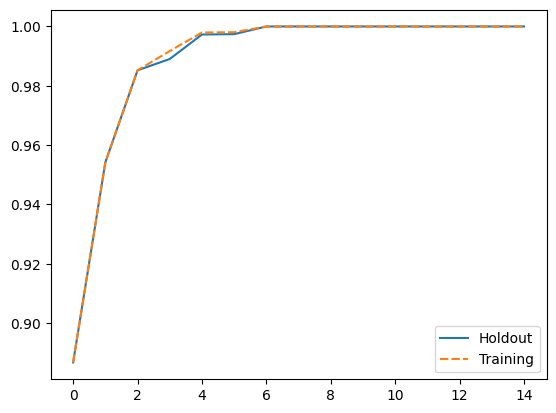

In [25]:
#plot sales of each store as a line
fig, ax = plt.subplots()
sns.lineplot(data=df[['Holdout', 'Training']])
#ax.set_xlim(0,14)

##Matriz de confusión

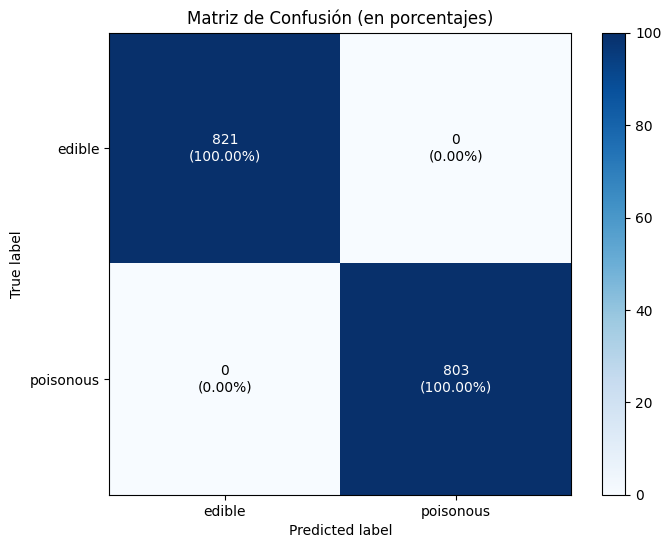

In [26]:
# Selecciona el mejor depth (profundidad) del modelo de árbol de decisión
best_depth = 6

# Inicializa el clasificador con la mejor profundidad encontrada
clf = DecisionTreeClassifier(max_depth=best_depth)

# Entrena el modelo con el conjunto de entrenamiento completo
clf.fit(X_train, y_train)

# Predice las etiquetas en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Convierte la matriz de confusión en porcentajes
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Crea un gráfico personalizado con anotaciones
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Define las etiquetas de clase
class_names = ['edible', 'poisonous']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title="Matriz de Confusión (en porcentajes)",
       ylabel='True label',
       xlabel='Predicted label')

# Anotar la matriz de confusión con los valores de porcentaje y el número de observaciones
fmt = '.2f'
thresh = cm_percentage.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)",
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > thresh else "black")

plt.show()

##Sensibilidad y especificidad del modelo

In [27]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = cm.ravel()

# Calcular sensibilidad y especificidad
sensibilidad = TP / (TP + FN)  # Verdaderos positivos sobre el total de positivos reales
especificidad = TN / (TN + FP)  # Verdaderos negativos sobre el total de negativos reales

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Sensibilidad: 1.0000
Especificidad: 1.0000


##Curva ROC y área bajo la curva

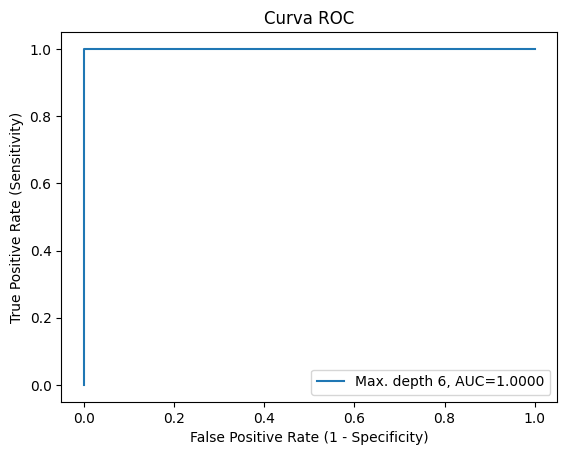

In [28]:
# Inicializa el clasificador con la mejor profundidad
clf = DecisionTreeClassifier(max_depth=best_depth)
clf = clf.fit(X_train, y_train)

# Obtener las probabilidades de predicción para la clase positiva (1)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calcular las tasas de falsos positivos y verdaderos positivos
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.plot(fpr, tpr, label=f"Max. depth {best_depth}, AUC={auc:.4f}")
plt.legend(loc=4)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Curva ROC")
plt.show()

##Cross-validation

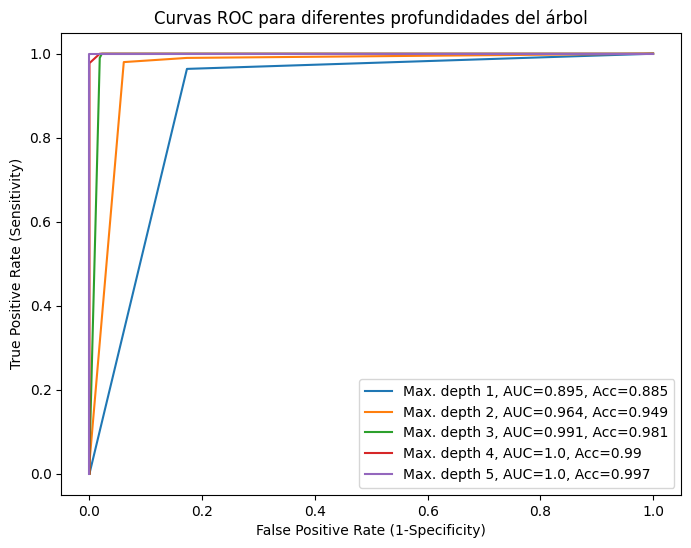

In [29]:
# Define el rango de profundidades que deseas probar
depths = range(1, 6)

# Define la figura para la gráfica
plt.figure(figsize=(8, 6))

# Itera sobre las diferentes profundidades del árbol de decisión
for depth in depths:
    # Inicializa el clasificador con la profundidad actual
    clf = DecisionTreeClassifier(max_depth=depth)

    # Entrena el modelo con el conjunto de entrenamiento
    clf = clf.fit(X_train, y_train)

    # Obtener las probabilidades de predicción para la clase positiva (1)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calcular las tasas de falsos positivos y verdaderos positivos
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Calcular el AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Configuración de K-Fold Cross Validation (10 divisiones)
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)

    # Realizar la validación cruzada para obtener la precisión promedio
    results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')

    # Graficar la curva ROC para cada profundidad
    plt.plot(fpr, tpr, label=f"Max. depth {depth}, AUC={round(auc, 3)}, Acc={round(results.mean(), 3)}")

# Configuración de la gráfica
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Curvas ROC para diferentes profundidades del árbol")
plt.legend(loc=4)
plt.show()

Matriz de correlación

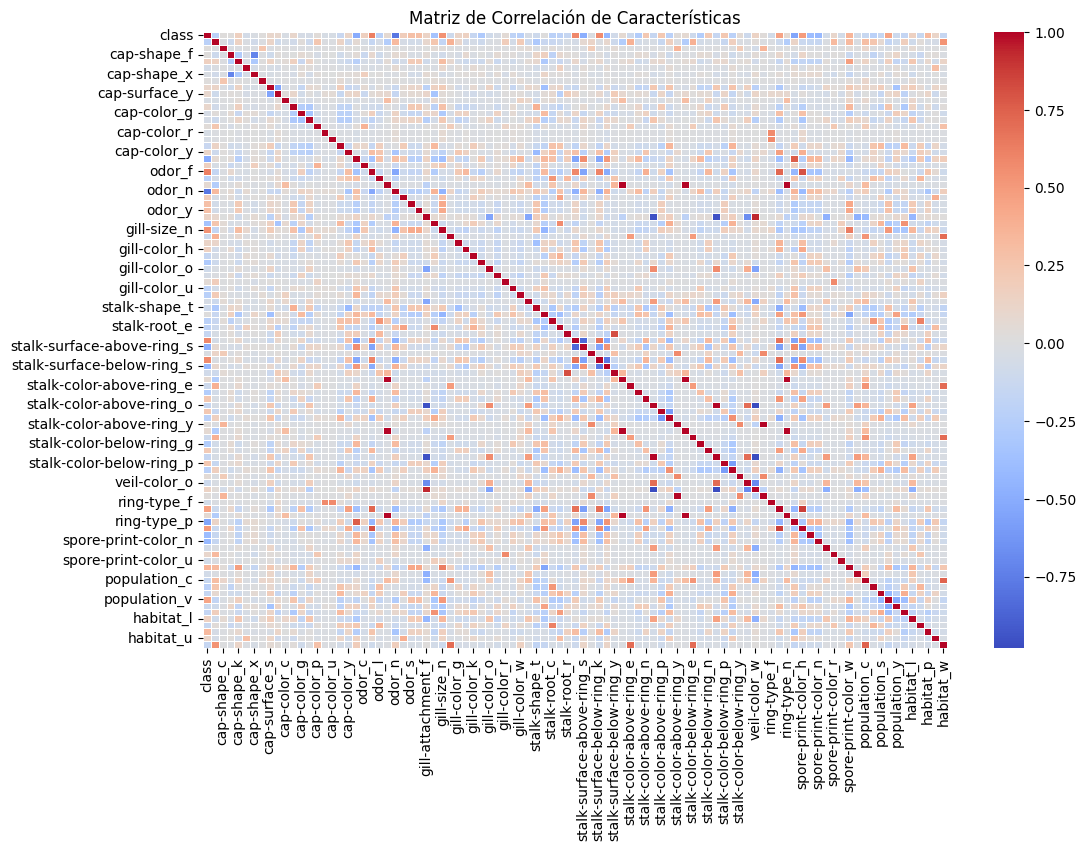

In [30]:
# Calcula la matriz de correlación
corr_matrix = data_encoded.corr()

# Configura el tamaño de la figura para el mapa de calor
plt.figure(figsize=(12, 8))

# Crea un mapa de calor con la matriz de correlación
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Configura el título y muestra el gráfico
plt.title('Matriz de Correlación de Características')
plt.show()

## Conclusiones

Después de entrenar árboles de decisión con profundidades que varían de 1 a 15 niveles y utilizando una validación cruzada con k-folds (k=5), se obtuvo una matriz de confusión perfecta. Aunque esto podría sugerir un sobreajuste o la presencia de una o más variables altamente correlacionadas con la variable objetivo, la matriz de correlación no refleja este problema. En general, las diferencias entre los modelos con distintos parámetros no fueron tan evidentes en este caso, ni se observó una evolución clara a lo largo de los entrenamientos y evaluaciones. Sin embargo, el ejercicio demuestra de manera efectiva cómo realizar una evaluación exhaustiva del modelo, proporcionando una base sólida para determinar si un modelo es suficientemente bueno con un respaldo justificado.

Se encontro un modelo con una accuracy del 100% y con curvas casi perfectas.